# imports

In [1]:
import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [13]:
def nice_obj(u1, u2, m1):
    x = 0.8 * u2 + 0.4 * u1 + 0.05 * m1
    return x

def datasets_make_regression(func, count_dots, random_state, dispersion, border):

    np.random.seed(random_state)
    x1 = np.linspace(border[0,0], border[0,1], count_dots)
    u1 = np.sin(x1*0.5) + np.random.normal(0,dispersion,len(x1))

    x2 = np.linspace(border[1,0], border[1,1], count_dots)
    u2 = np.power(x2, 1/2) + np.random.normal(0,dispersion,len(x2))
    #u2 = x2 + np.random.normal(0,dispersion,len(x2))

    x3 = np.linspace(border[2,0], border[2,1], count_dots)
    m1 = np.cos(0.3 * x3) + np.random.normal(0,dispersion,len(x3))

    y = func(u1,u2,m1) + np.random.normal(0,dispersion,len(x3))

    return u1, u2, m1, y

In [3]:
def nuke_Epa(x):
    if (abs(x) <= 1):
        return 3/4 * (1-x**2)
    else:
        return 0

In [5]:
def u1_regression(X_want, m_pred, x_train, u_train, m_train, par_blur, nuke):
# x_train - тренировочные значения переменных
# par_blur - зачения параметра размытости [значение параметра для X, значение параметра для m]
# nuke - ссылка на ядерную функцию
# m_pred - последнее значение неуправляемой переменной
# X_want - желаемое значение X
# В итоге может получится значение NaN. В этом случае парметр размытости не подходит. На выходе: предстказанное значение функции в координатах X_pred
    up = 0
    down = 0
    size = len(x_train)
    for i in range(size):
        down+= nuke( (X_want - x_train[i])/par_blur[0]) * nuke( (m_pred - m_train[i])/par_blur[1])
        up += u_train[i] * nuke( (X_want - x_train[i])/par_blur[0]) * nuke( (m_pred - m_train[i])/par_blur[0])
    end = up/down
    if(np.isnan(end)):
        print(f'u1_regression bad par blue!')
        return 0
    return up/down

def u_2_regression(X_want,U_1_pred, m_pred, x_train, u2_train, u1_train, m_train, par_blur, nuke):
# x_train - тренировочные значения переменных
# par_blur - зачения параметра размытости [значение параметра для X, значение параметра для m, значение параметра для u1]
# nuke - ссылка на ядерную функцию
# u2_train - тренировочные значения для u2
# u1_train - тренировочные значения для u1
# U_1_pred - предсказанное на предыдущем шаге значение u1
# m_pred - последнее значение неуправляемой переменной
# X_want - желаемое значение X
# В итоге может получится значение NaN. В этом случае парметр размытости не подходит. На выходе: предстказанное значение функции в координатах X_pred
    up = 0
    down = 0
    size = len(x_train)
    for i in range(size):
        down += nuke( (X_want - x_train[i])/par_blur[0]) * nuke( (m_pred - m_train[i])/par_blur[1]) * nuke( (U_1_pred - u1_train[i])/par_blur[2])
        up += u2_train[i] * nuke( (X_want - x_train[i])/par_blur[0]) * nuke( (m_pred - m_train[i])/par_blur[1]) * nuke( (U_1_pred - u1_train[i])/par_blur[2])
    
    end = up/down
    if(np.isnan(end)):
        print(f'u2_regression bad par blue!')
        return 0
    return up/down

def outside_m(m,delta_m,dispersion):  
    m1 = np.cos(0.3 * (m+delta_m)) + np.random.normal(0,dispersion)
    return m1


# Выборка

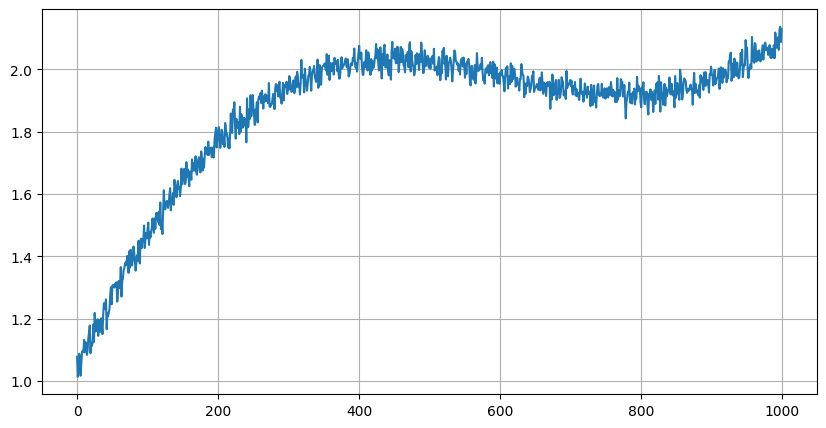

In [14]:
nuke = nuke_Epa
count_dots = 1000 # размер интервала разбиения генерируемого набора данных
noise_per = 0.15
random_state = 10
dispersion = 0.02
border = np.array([ [ 1, 10],
                    [ 1, 10],
                    [ 1, 10] ])

u1, u2, m1, x = datasets_make_regression(nice_obj, count_dots, random_state, dispersion, border)
data = pd.DataFrame()
data['X'] = x
data['u_1'] = u1
data['u_2'] = u2
data['m_1'] = m1
T = np.stack((u1,u2,m1),axis=1)

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()
ax.plot(data['X'])
ax.grid()
plt.show()

$u(t) = Kp * e(t)$,

где:

$u(t)$ — управляющее воздействие;
$Kp$ — коэффициент усиления регулятора;
$e(t)$ — ошибка регулирования.


$e(t)=x_{зад}(t)-x(t)$,

где:

$x_{зад}$ — заданное значение регулируемой величины,
$x$ — текущее значение регулируемой величины (предыдущее).


In [30]:
def X_want_cos(x):
    return 2 + 0.3*np.cos(x/100)
def X_want_hevi(x):
    if (x<200): return 5
    elif(x<400): return 10
    elif(x<600): return 7
    else: return 5.5

In [8]:
curr_nuke = nuke_Epa
X_want = 5.8
parameters_blur = [0.2, 0.8, 0.8]
delta_m = 0.1
K_p = 0.3 # коэффициент усиления регулятора
e = 0.0001 # ошибка регулирования
correction = 0.000001

for step in range(1000):
    correction = K_p * (X_want - x[-1])
    m1 = np.append( m1 , outside_m(m1[-1],delta_m, dispersion) )
    u_1_next = u1_regression(X_want = X_want, m_pred = m1[-1], x_train = x, u_train = u1, m_train = m1, par_blur=parameters_blur, nuke=curr_nuke)        # возможно надо обрезать m1, чтобы был без последнего элемента
    u_1_next += correction
    u1 = np.append(u1, u_1_next)
    u_2_next = u_2_regression(X_want = X_want,U_1_pred = u_1_next, m_pred = m1[-1], x_train = x, u2_train=u2, u1_train=u1, m_train=m1, par_blur = parameters_blur, nuke = curr_nuke)
    u_2_next += correction
    u2 = np.append(u2, u_2_next)

    X_currend = nice_obj(u1[-1], u2[-1], m1[-1])
    x = np.append( x, X_currend )



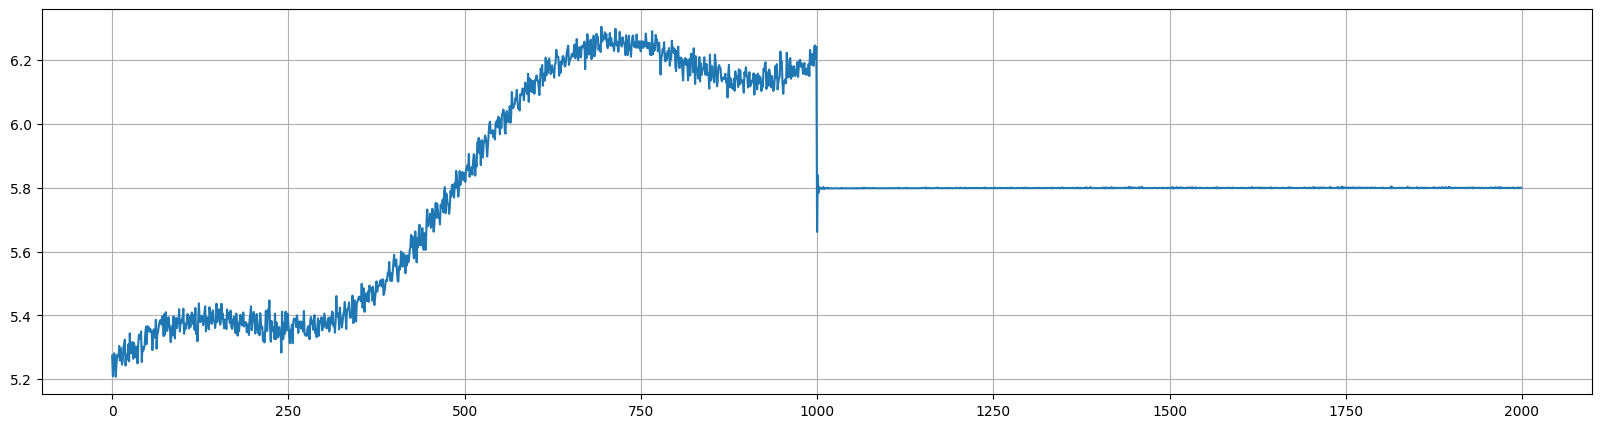

In [9]:
fig = plt.figure(figsize =(20, 5))
ax = plt.axes()
ax.plot(x)
ax.grid()
plt.show()

In [43]:
def find_borders(train, dot, blur):
    maxi = train[ np.argmax(train) ]
    mini = train[ np.argmin(train) ]
    if dot > ( maxi + 0.2*blur): return maxi + 0.2*blur
    elif dot < ( mini + 0.2*blur): return mini - 0.2*blur
    else: return dot

step=0
X_want=2.3
step=1
X_want=2.2999850001249995
step=2
X_want=2.2999400019999734
step=3
X_want=2.2998650101246962
step=4
X_want=2.2997600319982934
step=5
X_want=2.2996250781184897
step=6
X_want=2.2994601619805612
step=7
X_want=2.2992653000759837
step=8
X_want=2.299040511890786
step=9
X_want=2.2987858199035984
step=10
X_want=2.2985012495834076
step=11
X_want=2.298186829387009
step=12
X_want=2.2978425907561597
step=13
X_want=2.2974685681144362
step=14
X_want=2.297064798863791
step=15
X_want=2.2966313233808124
step=16
X_want=2.296168185012688
step=17
X_want=2.295675430072868
step=18
X_want=2.2951531078364367
step=19
X_want=2.294601270535181
step=20
X_want=2.2940199733523725
step=21
X_want=2.2934092744172445
step=22
X_want=2.2927692347991817
step=23
X_want=2.2920999185016124
step=24
X_want=2.291401392455609
step=25
X_want=2.2906737265131936
step=26
X_want=2.289916993440354
step=27
X_want=2.289131268909767
step=28
X_want=2.288316631493231
step=29
X_want=2.287473162653809
step=30
X_want=2

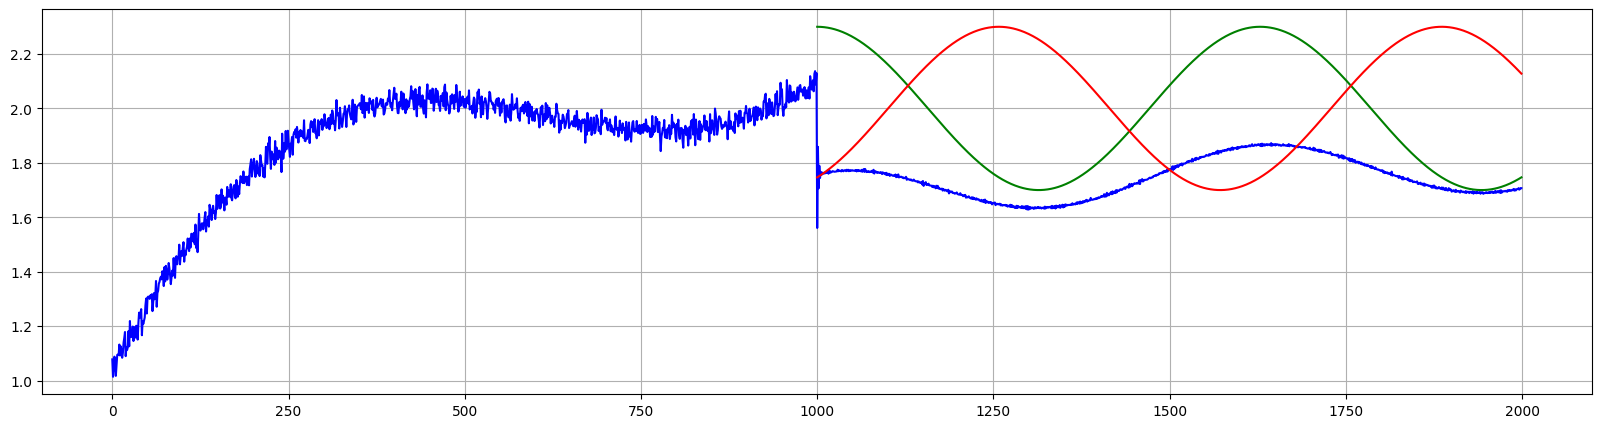

In [53]:
curr_nuke = nuke_Epa
u1, u2, m1, x = datasets_make_regression(nice_obj, count_dots, random_state, dispersion, border)
X_want = 5.8
parameters_blur = [5, 0.8, 0.8, 0.8] # зачения параметра размытости [значение параметра для X, значение параметра для m, значение параметра для u1, значение параметра для u2] последнее чтобы модель не поломалась
delta_m = 0.04382228452903661
K_p = 0.4 # коэффициент усиления регулятора
e = 0.0000 # ошибка регулирования
correction = 0.000001
difference = []
count_of_steps = 1000

for step in range(count_of_steps):
    X_want = X_want_cos(step)
    print(f'{step=}\n{X_want=}')
    correction = K_p * (X_want - x[-1])
    m1 = np.append( m1 , outside_m(m1[-1],delta_m, dispersion) )
    #X_want = find_borders(x, X_want, parameters_blur[0])
    u_1_next = u1_regression(X_want = X_want, m_pred = m1[-1], x_train = x, u_train = u1, m_train = m1, par_blur=parameters_blur, nuke=curr_nuke)        # возможно надо обрезать m1, чтобы был без последнего элемента
    if (np.isnan(u_1_next)):
        print(f'u1 bed par blur\n{step=}')
        break
    u_1_next += correction
    u_1_next = find_borders(u1, u_1_next, parameters_blur[2])
    u1 = np.append(u1, u_1_next)
    u_2_next = u_2_regression(X_want = X_want,U_1_pred = u_1_next, m_pred = m1[-1], x_train = x, u2_train=u2, u1_train=u1, m_train=m1, par_blur = parameters_blur, nuke = curr_nuke)
    if (u_2_next == np.nan):
        print(f'u2 bed par blur\n{step=}')
        break
    u_2_next += correction
    u_2_next = find_borders(u2, u_2_next, parameters_blur[3])
    u2 = np.append(u2, u_2_next)
    X_currend = nice_obj(u1[-1], u2[-1], m1[-1])
    difference.append([ step, X_want, correction**2 ])
    x = np.append( x, X_currend )

difference = np.array(difference)
print(f'Среднеквадратическая ошибка: {difference[:,2].sum()/count_of_steps}')


fig = plt.figure(figsize =(20, 5))
ax = plt.axes()
ax.plot(list(range(len(x))),x,color="blue")
ax.plot(1000+difference[:,0],difference[:,1],color='green')
ax.plot(1000+difference[:,0],X_want_cos(999+difference[:,0]),color='red')
ax.grid()
plt.show()

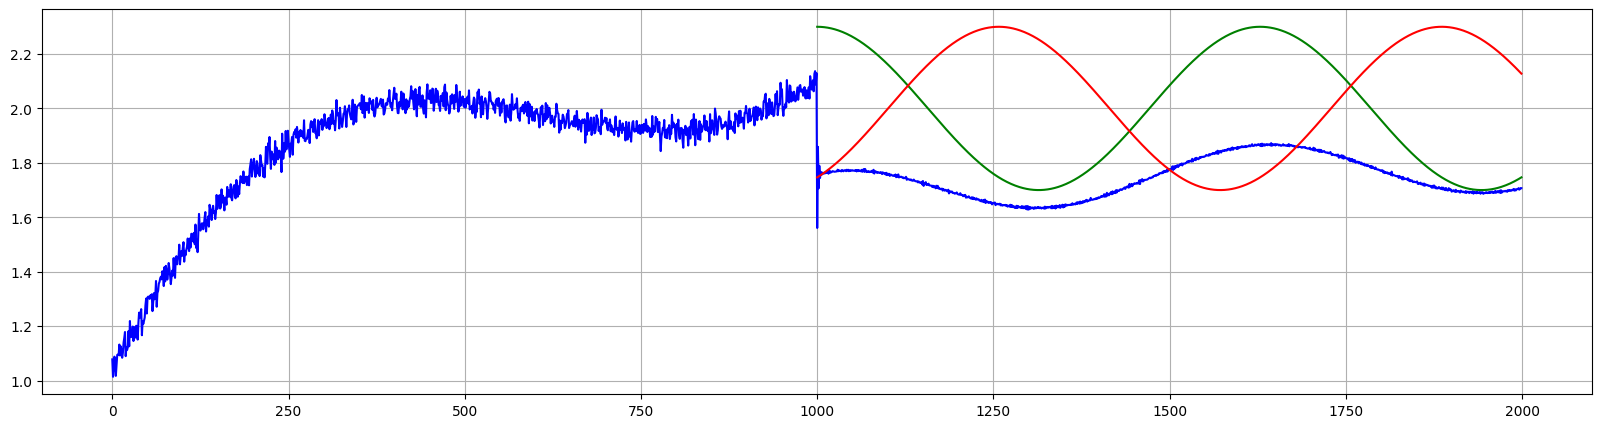

In [54]:
fig = plt.figure(figsize =(20, 5))
ax = plt.axes()
ax.plot(list(range(len(x))),x,color="blue")
ax.plot(1000+difference[:,0],difference[:,1],color='green')
ax.plot(1000+difference[:,0],X_want_cos(999+difference[:,0]),color='red')
ax.grid()
plt.show()

step=0
X_want=5
step=1
X_want=5
step=2
X_want=5
step=3
X_want=5
step=4
X_want=5
step=5
X_want=5
step=6
X_want=5
step=7
X_want=5
step=8
X_want=5
step=9
X_want=5
step=10
X_want=5
step=11
X_want=5
step=12
X_want=5
step=13
X_want=5
step=14
X_want=5
step=15
X_want=5
step=16
X_want=5
step=17
X_want=5
step=18
X_want=5
step=19
X_want=5
step=20
X_want=5
step=21
X_want=5
step=22
X_want=5
step=23
X_want=5
step=24
X_want=5
step=25
X_want=5
step=26
X_want=5
step=27
X_want=5
step=28
X_want=5
step=29
X_want=5
step=30
X_want=5
step=31
X_want=5
step=32
X_want=5
step=33
X_want=5
step=34
X_want=5
step=35
X_want=5
step=36
X_want=5
step=37
X_want=5
step=38
X_want=5
step=39
X_want=5
step=40
X_want=5
step=41
X_want=5
step=42
X_want=5
step=43
X_want=5
step=44
X_want=5
step=45
X_want=5
step=46
X_want=5
step=47
X_want=5
step=48
X_want=5
step=49
X_want=5
step=50
X_want=5
step=51
X_want=5
step=52
X_want=5
step=53
X_want=5
step=54
X_want=5
step=55
X_want=5
step=56
X_want=5
step=57
X_want=5
step=58
X_want=5
step=59

C:\Users\KoVaRu\AppData\Local\Temp\ipykernel_5096\795867813.py:14: RuntimeWarning: invalid value encountered in double_scalars
  end = up/down
C:\Users\KoVaRu\AppData\Local\Temp\ipykernel_5096\795867813.py:37: RuntimeWarning: invalid value encountered in double_scalars
  end = up/down


u2_regression bad par blue!
step=220
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=221
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=222
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=223
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=224
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=225
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=226
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=227
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=228
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=229
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=230
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=231
X_want=10
u1_regression bad par blue!
u2_regression bad par blue!
step=232
X_want=10
u1_regression bad par blue!
u2_regression bad par blu

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

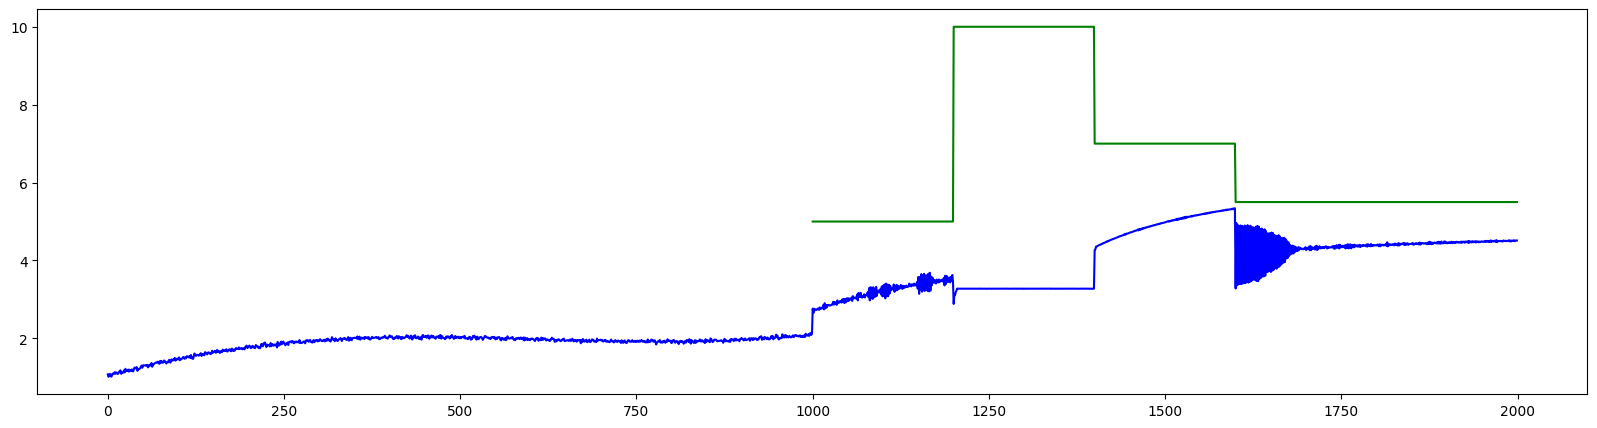

In [51]:
curr_nuke = nuke_Epa
u1, u2, m1, x = datasets_make_regression(nice_obj, count_dots, random_state, dispersion, border)
X_want = 5.8
parameters_blur = [5, 0.8, 0.8, 0.8] # зачения параметра размытости [значение параметра для X, значение параметра для m, значение параметра для u1, значение параметра для u2] последнее чтобы модель не поломалась
delta_m = 0.04382228452903661
K_p = 0.4 # коэффициент усиления регулятора
e = 0.0000 # ошибка регулирования
correction = 0.000001
difference = []
count_of_steps = 1000

for step in range(count_of_steps):
    X_want = X_want_hevi(step)
    print(f'{step=}\n{X_want=}')
    correction = K_p * (X_want - x[-1])
    m1 = np.append( m1 , outside_m(m1[-1],delta_m, dispersion) )
    #X_want = find_borders(x, X_want, parameters_blur[0])
    u_1_next = u1_regression(X_want = X_want, m_pred = m1[-1], x_train = x, u_train = u1, m_train = m1, par_blur=parameters_blur, nuke=curr_nuke)        # возможно надо обрезать m1, чтобы был без последнего элемента
    if (np.isnan(u_1_next)):
        print(f'u1 bed par blur\n{step=}')
        break
    u_1_next += correction
    u_1_next = find_borders(u1, u_1_next, parameters_blur[2])
    u1 = np.append(u1, u_1_next)
    u_2_next = u_2_regression(X_want = X_want,U_1_pred = u_1_next, m_pred = m1[-1], x_train = x, u2_train=u2, u1_train=u1, m_train=m1, par_blur = parameters_blur, nuke = curr_nuke)
    if (u_2_next == np.nan):
        print(f'u2 bed par blur\n{step=}')
        break
    u_2_next += correction
    u_2_next = find_borders(u2, u_2_next, parameters_blur[3])
    u2 = np.append(u2, u_2_next)
    X_currend = nice_obj(u1[-1], u2[-1], m1[-1])
    difference.append([ step, X_want, correction**2 ])
    x = np.append( x, X_currend )

difference = np.array(difference)
print(f'Среднеквадратическая ошибка: {difference[:,2].sum()/count_of_steps}')


fig = plt.figure(figsize =(20, 5))
ax = plt.axes()
ax.plot(list(range(len(x))),x,color="blue")
ax.plot(1000+difference[:,0],difference[:,1],color='green')
ax.plot(1000+difference[:,0],X_want_hevi(1000+difference[:,0]),color='red')
ax.grid()
plt.show()

In [106]:
type(u1[-1])

numpy.float64

Среднеквадратическая ошибка: 0.004012553785005253


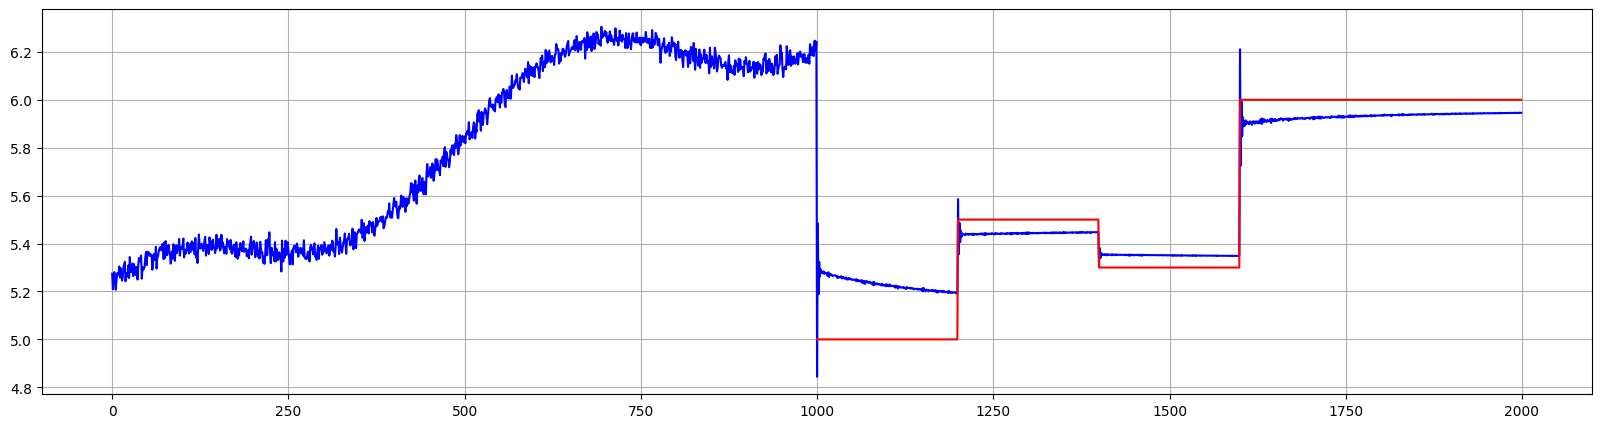

In [81]:
curr_nuke = nuke_Epa
u1, u2, m1, x = datasets_make_regression(nice_obj, count_dots, random_state, dispersion, border)
X_want = 5.8
parameters_blur = [0.6, 0.4, 0.5] # зачения параметра размытости [значение параметра для X, значение параметра для m, значение параметра для u1]
delta_m = 0.05
K_p = 0.5 # коэффициент усиления регулятора
e = 0.0001 # ошибка регулирования
correction = 0.000001
difference = []
count_of_steps = 1000

for step in range(count_of_steps):
    X_want = X_want_hevi(step)
    #print(f'{step=}\n{X_want=}')
    correction = K_p * (X_want - x[-1])
    m1 = np.append( m1 , outside_m(m1[-1],delta_m, dispersion) )
    u_1_next = u1_regression(X_want = X_want, m_pred = m1[-1], x_train = x, u_train = u1, m_train = m1, par_blur=parameters_blur, nuke=curr_nuke)        # возможно надо обрезать m1, чтобы был без последнего элемента
    u_1_next += correction
    u1 = np.append(u1, u_1_next)
    u_2_next = u_2_regression(X_want = X_want,U_1_pred = u_1_next, m_pred = m1[-1], x_train = x, u2_train=u2, u1_train=u1, m_train=m1, par_blur = parameters_blur, nuke = curr_nuke)
    u_2_next += correction
    u2 = np.append(u2, u_2_next)

    X_currend = nice_obj(u1[-1], u2[-1], m1[-1])
    difference.append([ step, X_want, correction**2 ])
    x = np.append( x, X_currend )

difference = np.array(difference)
print(f'Среднеквадратическая ошибка: {difference[:,2].sum()/count_of_steps}')


fig = plt.figure(figsize =(20, 5))
ax = plt.axes()
ax.plot(list(range(len(x))),x,color="blue")
ax.plot(1000+difference[:,0],difference[:,1],color='red')
ax.grid()
plt.show()